In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv

In [69]:
def crop_resize_clean(path_picture):
    print(path_picture)
    #path = str(path_picture)
    #print(path)
    image = cv2.imread(path_picture)
    #plt.imshow(image)
    # Détection d'objet
    img_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(img_grey, thresh=40, maxval=255, type=0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    max_numb = 0
    for contour in contours:
        if len(contour) > max_numb:
            max_numb = len(contour)
            cnt = contour
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Rognage et redimensionnement autour de l'objet détecté

    height = 106
    width = 106
    dim = (width, height)

    img = cv2.imread(path_picture)
    img_crop = img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)]

    resized = cv2.resize(img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)], dim, interpolation=cv2.INTER_AREA)

    # Nettoyage de l'image redimensionnée

    blur = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)

    #markers = markers + 1

    markers = cv2.watershed(blur, markers)

    center = markers[round(img_crop.shape[0]/2), round(img_crop.shape[1]/2)]

    masque = np.array(markers)
    blur2 = blur.copy()
    masque[:,:] = 0
    masque[markers == center] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    masque = cv2.dilate(masque.astype(np.uint8), kernel, iterations = 1)
    masque = cv2.blur(masque.astype(float), (5,5))

    for i in range(3):
        blur2[:,:,i] = (masque*blur[:,:,i]/255.0).astype(np.uint8)

    return blur2

sample_class_2/208686.jpg


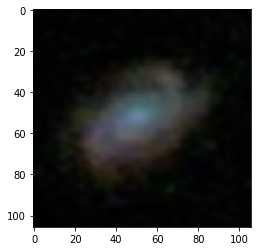

In [71]:
final = crop_resize_clean('sample_class_2/208686.jpg')

plt.imshow(final)

In [78]:
Y = pd.read_csv('training_solutions_rev1.csv').iloc[:,:4]
Y

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000
61574,999950,0.901216,0.098784,0.000000
61575,999958,0.202841,0.777376,0.019783
61576,999964,0.091000,0.909000,0.000000


In [74]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

Using TensorFlow backend.
